Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 146s 737ms/step - accuracy: 0.7526 - loss: 0.5785 - val_accuracy: 0.9682 - val_loss: 0.1052
Epoch 2/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 137s 726ms/step - accuracy: 0.9450 - loss: 0.1548 - val_accuracy: 0.9782 - val_loss: 0.0789
Epoch 3/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 157s 834ms/step - accuracy: 0.9469 - loss: 0.1335 - val_accuracy: 0.9749 - val_loss: 0.0779
Epoch 4/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 143s 751ms/step - accuracy: 0.9622 - loss: 0.1019 - val_accuracy: 0.9808 - val_loss: 0.0662
Epoch 5/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 138s 732ms/step - accuracy: 0.9673 - loss: 0.0902 - val_accuracy: 0.9841 - val_loss: 0.0595
Epoch 6/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 155s 821ms/step - accuracy: 0.9694 - loss: 0.0828 - val_accuracy: 0.9841 - val_loss: 0.0551
Epoch 7/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 157s 832ms/step - accuracy: 0.9728 - loss: 0.0785 - val_accuracy: 0.9835 - val_loss: 0.0543
Epoch 8/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 159s 839ms/step - accuracy: 0.9714 -

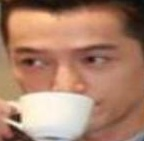

Prediction: No Mask (Confidence: 0.93)


(np.int64(0), np.float32(0.92625386))

In [ ]:

# 1️⃣ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2️⃣ Import libraries
import os
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from google.colab.patches import cv2_imshow

# 3️⃣ Function to load images
def load_images_from_folder(folder, label):
    images, labels = [], []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)
    return images, labels

# 4️⃣ Dataset paths
with_mask_path = '/content/drive/MyDrive/maskproj/with_mask'
without_mask_path = '/content/drive/MyDrive/maskproj/without_mask'

# 5️⃣ Load dataset
with_mask_images, with_mask_labels = load_images_from_folder(with_mask_path, 1)
without_mask_images, without_mask_labels = load_images_from_folder(without_mask_path, 0)

# Combine data
X = np.array(with_mask_images + without_mask_images, dtype='float32')
y = np.array(with_mask_labels + without_mask_labels)

# Preprocess input for MobileNetV2
X = preprocess_input(X)

# One-hot encode labels
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 2)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6️⃣ Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# 7️⃣ Build model with MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 8️⃣ Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 9️⃣ Train model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=15,
                    validation_data=(X_test, y_test))

# 1️⃣0️⃣ Evaluate model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

# 1️⃣1️⃣ Predictions and metrics
y_train_pred_classes = np.argmax(model.predict(X_train), axis=1)
y_test_pred_classes = np.argmax(model.predict(X_test), axis=1)
y_train_classes = np.argmax(y_train, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Train Precision:", precision_score(y_train_classes, y_train_pred_classes))
print("Train Recall:", recall_score(y_train_classes, y_train_pred_classes))
print("Train F1 Score:", f1_score(y_train_classes, y_train_pred_classes))
print("Test Precision:", precision_score(y_test_classes, y_test_pred_classes))
print("Test Recall:", recall_score(y_test_classes, y_test_pred_classes))
print("Test F1 Score:", f1_score(y_test_classes, y_test_pred_classes))

# 1️⃣2️⃣ Predict on a single image
def predict_image(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not read image")
        return
    img_resized = cv2.resize(img, (128,128))
    img_scaled = preprocess_input(np.expand_dims(img_resized, axis=0))

    pred = model.predict(img_scaled)
    class_index = np.argmax(pred)
    confidence = pred[0][class_index]

    cv2_imshow(img)

    if class_index == 1:
        print(f"Prediction: Mask (Confidence: {confidence:.2f})")
    else:
        print(f"Prediction: No Mask (Confidence: {confidence:.2f})")

    return class_index, confidence

# Example usage
image_path = '/content/drive/MyDrive/maskproj/test/without_mask/without_mask_1002.jpg'
predict_image(image_path, model)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')